reference:
    
https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

# 0. Importing Packages

In [1]:
import numpy as np
from numpy import array, hstack
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns


from datetime import datetime, timedelta


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.utils import shuffle

from sklearn import preprocessing

rcParams['figure.figsize'] = 20, 6

In [3]:
from keras.models import load_model
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.utils import Sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import re


Using TensorFlow backend.


# 1. Loading Data

In [4]:
# Getting all the files in the directory.
def existing_file_list(path):
    ''' Extracting File Names '''

    allFiles = glob.glob(path + "/*.csv")
    new_list = []
    for i in allFiles:
        before = 'original\\'
        after = '_minute'
        ticker = i[i.find(before) + len(before) : i.find(after)]
        new_list.append(ticker)    
    #list_ticker = list(filter(None, text))  # drop all the empty elements and put them in a list
        
    return (new_list)


In [5]:
mypath = 'D:\\OneDrive - Georgia State University\\Data Science\\AKDSPW\\Solar Farm Forecasting\\'
datapath = mypath + 'Data\\'

from os import listdir
from os.path import isfile, join
data_list = [f for f in listdir(datapath) if isfile(join(datapath, f))]

In [6]:
datapath

'D:\\OneDrive - Georgia State University\\Data Science\\AKDSPW\\Solar Farm Forecasting\\Data\\'

In [7]:
data_list

['15min_dropNA_onlylag.csv',
 '15min_linearNA_onlylag.csv',
 'SOLARFARM1_15MIN_201001_201804.csv']

In [8]:
# Import the data with DateTime index
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')

data = pd.read_csv(datapath + data_list[1], parse_dates=['dattim'],index_col='dattim', date_parser=dateparse, engine='python')

In [9]:
# move 'avepow' to the very end for split_squences function

data = data[['avepow_t-1', 'avepow_t-2', 'avepow_t-3', 'avepow_t-4',
       'avepow_t-5', 'avepow_t-6', 'avepow_t-7', 'avepow_t-8', 'avepow_t-9',
       'avepow_t-10', 'avepow_t-11', 'avepow_t-12', 'avepow_t-13', 'avepow']]

data.columns

Index(['avepow_t-1', 'avepow_t-2', 'avepow_t-3', 'avepow_t-4', 'avepow_t-5',
       'avepow_t-6', 'avepow_t-7', 'avepow_t-8', 'avepow_t-9', 'avepow_t-10',
       'avepow_t-11', 'avepow_t-12', 'avepow_t-13', 'avepow'],
      dtype='object')

In [10]:
data.head()
data.tail()


data.dtypes

,avepow_t-1,avepow_t-2,avepow_t-3,avepow_t-4,avepow_t-5,avepow_t-6,avepow_t-7,avepow_t-8,avepow_t-9,avepow_t-10,avepow_t-11,avepow_t-12,avepow_t-13,avepow
dattim,,,,,,,,,,,,,,
2010-01-01 03:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 03:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 04:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 04:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,avepow_t-1,avepow_t-2,avepow_t-3,avepow_t-4,avepow_t-5,avepow_t-6,avepow_t-7,avepow_t-8,avepow_t-9,avepow_t-10,avepow_t-11,avepow_t-12,avepow_t-13,avepow
dattim,,,,,,,,,,,,,,
2018-04-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-30 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-30 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04-30 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


avepow_t-1     float64
avepow_t-2     float64
avepow_t-3     float64
avepow_t-4     float64
avepow_t-5     float64
avepow_t-6     float64
avepow_t-7     float64
avepow_t-8     float64
avepow_t-9     float64
avepow_t-10    float64
avepow_t-11    float64
avepow_t-12    float64
avepow_t-13    float64
avepow         float64
dtype: object

Let’s understand the arguments one by one:

- parse_dates: This specifies the column which contains the date-time information. As we say above, the column name is ‘Month’.
 
- index_col: A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. So this argument tells pandas to use the ‘Month’ column as index.
 
- date_parser: This specifies a function which converts an input string into datetime variable. Be default Pandas reads data in format ‘YYYY-MM-DD HH:MM:SS’. If the data is not in this format, the format has to be manually defined. Something similar to the dataparse function defined here can be used for this purpose.

# 2. Preprocessing

In this section, I will prepare the dataset for feeding into LSTM network. Basically, I will do 4 things.

1. Transform data to stationary
2. Transform data to supervised learning
3. Split the data into train and test
4. Scale the data to (-1,1)

# 3) Splitting Data

## 3-1) Prepare Features and Labels  

In [11]:
def create_train_test(data):
    '''Create training and validation features and labels'''
    
    train, test = data['2017':'2017'], data['2018':'2018']
    
    return train, test

In [12]:
def normalization(data):
    '''normalizing the data'''
    
    scaler = preprocessing.MinMaxScaler()
    if len(data.columns) == 1:
        data = data.values.reshape(-1, 1)
    else:
        pass
    
    scaled = scaler.fit_transform(data)
    #scaled = pd.DataFrame(scaled, columns=data.columns, index = data.index)
    
    return scaled, scaler

In [13]:
train, test = create_train_test(data)
normalized_train, scaler = normalization(train)
normalized_test, scaler = normalization(test)


## 3-2) Reshape features

In [14]:
# multivariate data preparation

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
        
    
    return array(X), array(y)

In [15]:
# choose a number of time steps
n_steps = 13

# convert into input/output
x_train_reshaped, y_train = split_sequences(normalized_train, n_steps)
x_test_reshaped, y_test = split_sequences(normalized_test, n_steps)



In [16]:
print (f"shape of x_train_reshaped: {x_train_reshaped.shape}, \nshape of y_train: {y_train.shape}, \n\nshape of x_test_reshaped: {x_test_reshaped.shape}, \nshape of y_test: {y_test.shape}")

shape of x_train_reshaped: (35028, 13, 13), 
shape of y_train: (35028,), 

shape of x_test_reshaped: (11509, 13, 13), 
shape of y_test: (11509,)


# 4) Build and Train a Model

In [17]:
n_timesteps, n_features, n_outputs = x_train_reshaped.shape[1], x_train_reshaped.shape[2], 1

print (f"shape of number of timesteps: {n_timesteps} \nnumber of features: {n_features} \nnumber of outputs: {n_outputs}")

shape of number of timesteps: 13 
number of features: 13 
number of outputs: 1


## 4-1) First Model

In [18]:
'''# Returns a compiled model identical to the previous one
model = load_model('E:\Data Science\Personal_Project\RNN - Solar Farm\model\LSTM_Model.h5')'''

"# Returns a compiled model identical to the previous one\nmodel = load_model('E:\\Data Science\\Personal_Project\\RNN - Solar Farm\\model\\LSTM_Model.h5')"

In [49]:
# define model

model_LSTM = Sequential()
model_LSTM.add(LSTM(286, activation='sigmoid', input_shape = (n_timesteps, n_features)))
#model_LSTM.add(Dropout(0.1))
model_LSTM.add(Dense(100, activation='sigmoid'))
#model_LSTM.add(Dropout(0.1))
model_LSTM.add(Dense(50, activation='sigmoid'))
model_LSTM.add(Dense(n_outputs))

model_LSTM.compile(loss='mean_squared_error', optimizer='adam',  metrics=['accuracy'])



In [50]:
model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 286)               343200    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               28700     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 377,001
Trainable params: 377,001
Non-trainable params: 0
_________________________________________________________________


In [51]:
epochs = 700
batch_size = 128
verbose = 1
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

In [52]:
# fit network
history = model_LSTM.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split = 0.2, callbacks=callbacks)

Train on 28022 samples, validate on 7006 samples
Epoch 1/700
28022/28022 [==============================] - 15s 520us/step - loss: 0.0374 - acc: 0.4666 - val_loss: 0.0065 - val_acc: 0.5622
Epoch 2/700
28022/28022 [==============================] - 13s 471us/step - loss: 0.0096 - acc: 0.4687 - val_loss: 0.0037 - val_acc: 0.5622
Epoch 3/700
28022/28022 [==============================] - 13s 454us/step - loss: 0.0079 - acc: 0.4687 - val_loss: 0.0029 - val_acc: 0.5622
Epoch 4/700
28022/28022 [==============================] - 12s 438us/step - loss: 0.0067 - acc: 0.4687 - val_loss: 0.0034 - val_acc: 0.5622
Epoch 5/700
28022/28022 [==============================] - 13s 464us/step - loss: 0.0065 - acc: 0.4687 - val_loss: 0.0021 - val_acc: 0.5622
Epoch 6/700
28022/28022 [==============================] - 15s 539us/step - loss: 0.0061 - acc: 0.4687 - val_loss: 0.0030 - val_acc: 0.5622
Epoch 7/700
28022/28022 [==============================] - 16s 568us/step - loss: 0.0062 - acc: 0.4687 - val_lo

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

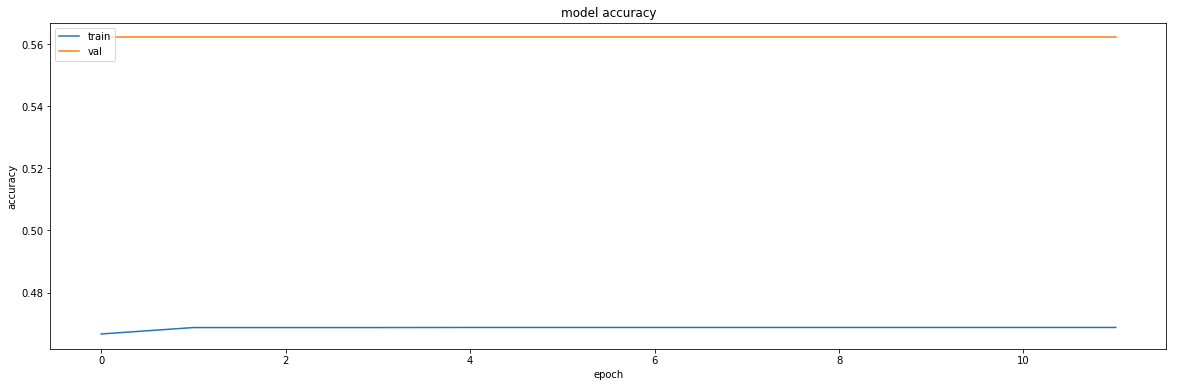

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

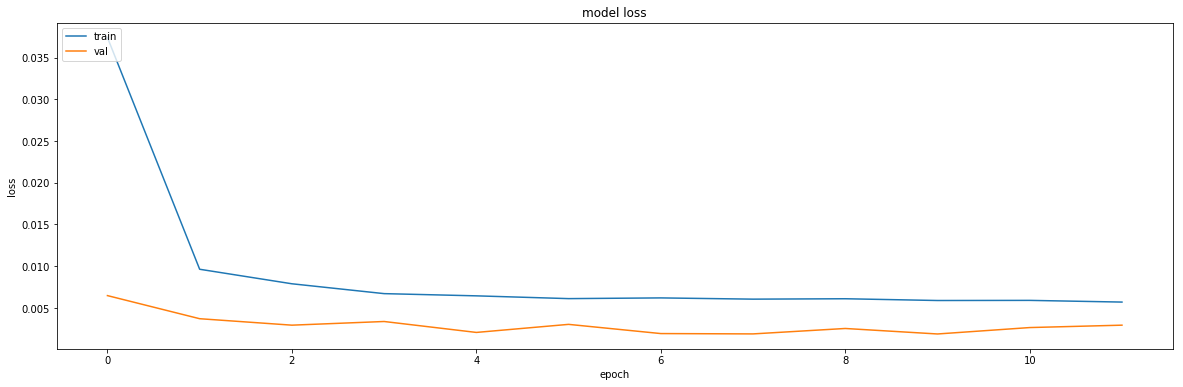

In [53]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
'''# Returns a compiled model identical to the previous one
model = load_model('E:\Data Science\Personal_Project\RNN - Solar Farm\model\LSTM_Model.h5')

y_predict = model.predict(x_test_reshaped, verbose)'''

"# Returns a compiled model identical to the previous one\nmodel = load_model('E:\\Data Science\\Personal_Project\\RNN - Solar Farm\\model\\LSTM_Model.h5')\n\ny_predict = model.predict(x_test_reshaped, verbose)"

In [55]:
history.history['loss']

[0.03740443765849086,
 0.009635975685888712,
 0.007896558617256105,
 0.006715701401686206,
 0.006450448220102637,
 0.00611798822798431,
 0.006203852161373187,
 0.006054614665788767,
 0.0061028621749222986,
 0.005892124068258919,
 0.005907570175199331,
 0.0057039656636469534]

In [56]:
y_predict = model_LSTM.predict(x_test_reshaped, verbose)
y_predict = y_predict.reshape(y_predict.shape[0],)

In [57]:
comparison = pd.DataFrame(data=np.column_stack((y_test,y_predict)),columns=['actual','prediction'])
comparison = comparison.set_index(test.index[n_steps-1:])

In [58]:
denormalizing_data = data.copy()
denormalizing_data.drop(columns = ['avepow'], inplace = True)
denormalizing_data['prediction'] = comparison['prediction']
denormalizing_data.dropna(axis=0,inplace=True)
denormalized_prediction = pd.DataFrame(scaler.inverse_transform(denormalizing_data), index=test.index[n_steps-1:], columns=denormalizing_data.columns)['prediction']

denormalizing_actual = data.copy()
denormalizing_actual.drop(columns = ['avepow'], inplace = True)
denormalizing_actual['actual'] = comparison['actual']
denormalizing_actual.dropna(axis=0,inplace=True)
denormalized_actual = pd.DataFrame(scaler.inverse_transform(denormalizing_actual), index=test.index[n_steps-1:], columns=denormalizing_actual.columns)['actual']

comparison = pd.concat([denormalized_actual, denormalized_prediction], axis=1)

In [59]:
comparison

,actual,prediction
dattim,,
2018-01-01 03:00:00,0.00,-29.722570
2018-01-01 03:15:00,0.00,-29.722570
2018-01-01 03:30:00,0.00,-29.722570
2018-01-01 03:45:00,0.00,-29.722570
2018-01-01 04:00:00,0.00,-29.722570
2018-01-01 04:15:00,0.00,-29.722570
2018-01-01 04:30:00,0.00,-29.722570
2018-01-01 04:45:00,0.00,-29.722570
2018-01-01 05:00:00,0.00,-29.722570


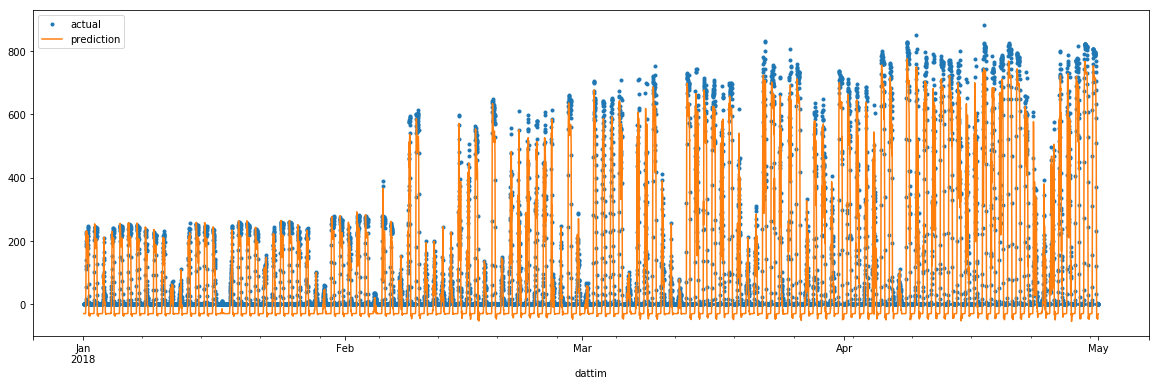

In [60]:
comparison.plot(style=['.','-'])

In [61]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [62]:
new_df = comparison
mse = mean_squared_error(new_df['actual'], new_df['prediction'])
mape = mean_absolute_percentage_error(new_df['actual'], new_df['prediction'])
mae = mean_absolute_error(new_df['actual'], new_df['prediction'])

#mean 

print(f'\nRMSE: {math.sqrt(mse)}\nMAE: {mae}')  


RMSE: 57.757017290633215
MAE: 41.859712571211546


D:\Programming\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [81]:
# Saving the result
comparison.to_csv(mypath + 'Result\\CNN_' + str(round((mae), 4)) + '.csv', index = True)

In [82]:
# Creates a HDF5 file 'my_model.h5'
model_LSTM.save(mypath + 'Model\\CNN_' + str(round((mae), 4))  + '.h5')

# Deletes the existing model
# del model  


# For Improvements: